# MODELO 3 - CGAN para generar un dígito del mnist a pedido del usuario

In [23]:
import tensorflow as tf
print(tf.__version__)

2.13.0


- Importo las librerias neceasarias

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation, Embedding, Concatenate
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

1


- Cargo el dataset

In [4]:
tags = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

(X_train, y_train), (X_test, y_test) = mnist.load_data()

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = np.reshape(X_train, [-1, img_size, img_size, 1])
X_train = np.repeat(X_train, 3, axis=-1)  # Convertir a 3 canales
X_train = (X_train - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_train = np.expand_dims(y_train, axis=-1) #expando la dimension de y_train

X_test = np.reshape(X_test, [-1, img_size, img_size, 1])
X_test = np.repeat(X_test, 3, axis=-1)  # Convertir a 3 canales
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]
y_test = np.expand_dims(y_test, axis=-1) # expando la dimension de y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 3)
(60000, 1)
(10000, 28, 28, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

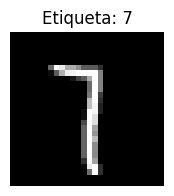

In [6]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(f"Etiqueta: {tags[y_train[idx][0]]}")
plt.show()

# Construcción del generador

In [7]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 256 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = Reshape((img_size_in, img_size_in, 256), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 14x14x256
    gen = BatchNormalization(name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 28x28x128
    gen = BatchNormalization(name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2DTranspose(3, (5, 5), strides=(1,1), activation='tanh', padding='same', name='Output_Conv2DTranspose_4')(gen)  # 28x28x3
    #---------------------------------------------------------------------------------#

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='generator_structure_m3.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [8]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 14x14x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 7x7x64
    fe = BatchNormalization(name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='Conv2D_3')(fe) # 7x7x128
    fe = BatchNormalization(name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(1, 1), padding='same', name='Conv2D_5')(fe) # 7x7x256
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    out_layer = Dense(1, activation='sigmoid', name='Output')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='discriminator_structure_m3.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [9]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10,num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("evolution", exist_ok=True)
  plt.savefig(f"evolution/digits_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [10]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [11]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [12]:
epoch_count = 50 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [13]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Generator_Dense (Dense)     (None, 12544)                1266944   ['Latent_Input[0][0]']        
                                                                                          

- Construyo el discriminador

In [14]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                500       ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 784)               39984     ['Embedding[1][0]']           
                                                                                                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [15]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = g_model([noise, real_labels], training = True) #  Genero imagenes falsas
            pred_real = d_model([real_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes reales
            pred_fake = d_model([generated_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes falsas

            g_loss = generator_loss(pred_fake) # Calculo la loss del generador
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        grads_g = gen_tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        grads_d = disc_tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes

        g_optimizer.apply_gradients(zip(grads_g, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador
        d_optimizer.apply_gradients(zip(grads_d, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [16]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([noise, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        g_loss = generator_loss(pred_fake) # Calculo la loss del generador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [ ]:
def train(train_dataset, test_dataset, epoch_count, batch_size):
    
    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0
 
    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento
            
            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train 
            g_loss_list_batch_train_aux[itern] = g_loss_train  
            d_loss_list_itern_train[itern_train_counter] = d_loss_train  
            g_loss_list_itern_train[itern_train_counter] = g_loss_train  
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train
            
            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1 

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo
            
            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test 
            d_loss_list_itern_test[itern_test_counter] = d_loss_test 
            g_loss_list_itern_test[itern_test_counter] = g_loss_test 
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test

            itern=itern+1 
        
        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_mnist_m3.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_mnist_m3.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_mnist_m3.keras")

Epoch:  1


Test - batch/batches: 100%|██████████| 625/625 [00:07<00:00, 84.86it/s]


Train - Época: 1 -- Generator Loss: 4.163486480712891, Discriminator Loss: 0.6087673902511597
Test - Época: 1 -- Generator Loss: 0.06725667417049408, Discriminator Loss: 5.524802207946777

Tomó 74.7197778224945 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  2


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.34it/s]


Train - Época: 2 -- Generator Loss: 4.233036518096924, Discriminator Loss: 0.46151041984558105
Test - Época: 2 -- Generator Loss: 1.2081965208053589, Discriminator Loss: 1.4340722560882568

Tomó 64.75702953338623 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.95it/s]


Train - Época: 3 -- Generator Loss: 4.373945713043213, Discriminator Loss: 0.44655901193618774
Test - Época: 3 -- Generator Loss: 0.47363531589508057, Discriminator Loss: 2.6556637287139893

Tomó 63.542492389678955 segundos. 


Epoch:  4


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.19it/s]


Train - Época: 4 -- Generator Loss: 4.430769920349121, Discriminator Loss: 0.44503718614578247
Test - Época: 4 -- Generator Loss: 0.00028425882919691503, Discriminator Loss: 18.084627151489258

Tomó 63.74323797225952 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.25it/s]


Train - Época: 5 -- Generator Loss: 4.477932929992676, Discriminator Loss: 0.44635897874832153
Test - Época: 5 -- Generator Loss: 3.5753514766693115, Discriminator Loss: 2.2937848567962646

Tomó 63.93384099006653 segundos. 


Epoch:  6


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 98.04it/s]


Train - Época: 6 -- Generator Loss: 4.434619903564453, Discriminator Loss: 0.4585321545600891
Test - Época: 6 -- Generator Loss: 3.71575927734375, Discriminator Loss: 2.5103721618652344

Tomó 64.0274224281311 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  7


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.11it/s]


Train - Época: 7 -- Generator Loss: 4.56400203704834, Discriminator Loss: 0.4455607831478119
Test - Época: 7 -- Generator Loss: 3.902198553085327, Discriminator Loss: 2.7468323707580566

Tomó 64.2459990978241 segundos. 


Epoch:  8


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.15it/s]


Train - Época: 8 -- Generator Loss: 4.576356410980225, Discriminator Loss: 0.44678691029548645
Test - Época: 8 -- Generator Loss: 6.327963829040527, Discriminator Loss: 5.563876628875732

Tomó 64.38814115524292 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.44it/s]


Train - Época: 9 -- Generator Loss: 4.538660049438477, Discriminator Loss: 0.4498825669288635
Test - Época: 9 -- Generator Loss: 4.493085861206055, Discriminator Loss: 3.253964900970459

Tomó 64.3674898147583 segundos. 


Epoch:  10


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.22it/s]


Train - Época: 10 -- Generator Loss: 4.83765172958374, Discriminator Loss: 0.43064987659454346
Test - Época: 10 -- Generator Loss: 6.2767181396484375, Discriminator Loss: 5.210437297821045

Tomó 63.838162422180176 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.39it/s]


Train - Época: 11 -- Generator Loss: 4.77524995803833, Discriminator Loss: 0.4459267556667328
Test - Época: 11 -- Generator Loss: 3.034942626953125, Discriminator Loss: 2.3140087127685547

Tomó 63.862680196762085 segundos. 


1/1 [==============================] - 0s 23ms/step
Epoch:  12


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.13it/s]


Train - Época: 12 -- Generator Loss: 4.69334077835083, Discriminator Loss: 0.44708722829818726
Test - Época: 12 -- Generator Loss: 7.111757755279541, Discriminator Loss: 5.860771656036377

Tomó 65.15808939933777 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.75it/s]


Train - Época: 13 -- Generator Loss: 5.028950214385986, Discriminator Loss: 0.4217430055141449
Test - Época: 13 -- Generator Loss: 5.923445224761963, Discriminator Loss: 4.774796962738037

Tomó 65.16109466552734 segundos. 


Epoch:  14


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.33it/s]


Train - Época: 14 -- Generator Loss: 6.299574851989746, Discriminator Loss: 0.3603440523147583
Test - Época: 14 -- Generator Loss: 8.593777656555176, Discriminator Loss: 7.539013862609863

Tomó 64.30626368522644 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.71it/s]


Train - Época: 15 -- Generator Loss: 7.199504375457764, Discriminator Loss: 0.31619080901145935
Test - Época: 15 -- Generator Loss: 4.678988456726074, Discriminator Loss: 3.4455528259277344

Tomó 64.71653294563293 segundos. 


Epoch:  16


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.84it/s] 


Train - Época: 16 -- Generator Loss: 5.159587383270264, Discriminator Loss: 0.4164173901081085
Test - Época: 16 -- Generator Loss: 4.467820167541504, Discriminator Loss: 3.302753448486328

Tomó 63.93434143066406 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  17


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.35it/s]


Train - Época: 17 -- Generator Loss: 9.162078857421875, Discriminator Loss: 0.15680518746376038
Test - Época: 17 -- Generator Loss: 43.15377426147461, Discriminator Loss: 52.16654968261719

Tomó 64.32959651947021 segundos. 


Epoch:  18


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.43it/s]


Train - Época: 18 -- Generator Loss: 15.828056335449219, Discriminator Loss: 2.170496736653149e-05
Test - Época: 18 -- Generator Loss: 27.743568420410156, Discriminator Loss: 21.34853744506836

Tomó 64.57479500770569 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.35it/s]


Train - Época: 19 -- Generator Loss: 15.623266220092773, Discriminator Loss: 2.3343429802480387e-06
Test - Época: 19 -- Generator Loss: 16.197906494140625, Discriminator Loss: 20.51704216003418

Tomó 64.23170185089111 segundos. 


Epoch:  20


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.02it/s]


Train - Época: 20 -- Generator Loss: 16.35350799560547, Discriminator Loss: 0.0018630584236234426
Test - Época: 20 -- Generator Loss: 14.906404495239258, Discriminator Loss: 0.005450038705021143

Tomó 64.37423086166382 segundos. 


Epoch:  21


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.78it/s]


Train - Época: 21 -- Generator Loss: 18.034343719482422, Discriminator Loss: 2.7404864795244066e-06
Test - Época: 21 -- Generator Loss: 26.81846809387207, Discriminator Loss: 25.693544387817383

Tomó 63.88462042808533 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  22


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.99it/s]


Train - Época: 22 -- Generator Loss: 15.943665504455566, Discriminator Loss: 7.55073131131212e-07
Test - Época: 22 -- Generator Loss: 21.693925857543945, Discriminator Loss: 14.203670501708984

Tomó 63.6311674118042 segundos. 


Epoch:  23


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.05it/s]


Train - Época: 23 -- Generator Loss: 17.159982681274414, Discriminator Loss: 1.1443393077570363e-07
Test - Época: 23 -- Generator Loss: 22.310100555419922, Discriminator Loss: 11.962977409362793

Tomó 63.524853229522705 segundos. 


Epoch:  24


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.05it/s]


Train - Época: 24 -- Generator Loss: 17.62140464782715, Discriminator Loss: 8.526641437356375e-08
Test - Época: 24 -- Generator Loss: 26.51029396057129, Discriminator Loss: 19.80156707763672

Tomó 63.72088074684143 segundos. 


Epoch:  25


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.99it/s]


Train - Época: 25 -- Generator Loss: 18.182621002197266, Discriminator Loss: 1.054965892421933e-07
Test - Época: 25 -- Generator Loss: 33.18910598754883, Discriminator Loss: 24.415376663208008

Tomó 64.08811974525452 segundos. 


Epoch:  26


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 98.35it/s]


Train - Época: 26 -- Generator Loss: 19.590795516967773, Discriminator Loss: 4.4448617586567707e-07
Test - Época: 26 -- Generator Loss: 30.261137008666992, Discriminator Loss: 15.169540405273438

Tomó 63.85773229598999 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  27


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.86it/s]


Train - Época: 27 -- Generator Loss: 19.058202743530273, Discriminator Loss: 4.909276754005987e-07
Test - Época: 27 -- Generator Loss: 41.854393005371094, Discriminator Loss: 54.43376159667969

Tomó 64.215744972229 segundos. 


Epoch:  28


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.93it/s]


Train - Época: 28 -- Generator Loss: 18.39974594116211, Discriminator Loss: 4.3129938376296195e-07
Test - Época: 28 -- Generator Loss: 40.08416748046875, Discriminator Loss: 47.616573333740234

Tomó 63.36467242240906 segundos. 


Epoch:  29


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.14it/s]


Train - Época: 29 -- Generator Loss: 17.827560424804688, Discriminator Loss: 3.701445336901088e-07
Test - Época: 29 -- Generator Loss: 37.831607818603516, Discriminator Loss: 55.66497039794922

Tomó 63.71334433555603 segundos. 


Epoch:  30


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.45it/s]


Train - Época: 30 -- Generator Loss: 20.220592498779297, Discriminator Loss: 0.027717219665646553
Test - Época: 30 -- Generator Loss: 10.310136795043945, Discriminator Loss: 0.0004402660415507853

Tomó 64.26434826850891 segundos. 


Epoch:  31


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.75it/s]


Train - Época: 31 -- Generator Loss: 18.17171287536621, Discriminator Loss: 0.033120013773441315
Test - Época: 31 -- Generator Loss: 11.562724113464355, Discriminator Loss: 0.11103498190641403

Tomó 63.39533877372742 segundos. 


1/1 [==============================] - 0s 23ms/step
Epoch:  32


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.19it/s]


Train - Época: 32 -- Generator Loss: 19.124433517456055, Discriminator Loss: 0.0444030836224556
Test - Época: 32 -- Generator Loss: 13.24860954284668, Discriminator Loss: 1.350172996520996

Tomó 63.95031428337097 segundos. 


Epoch:  33


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.96it/s]


Train - Época: 33 -- Generator Loss: 18.854625701904297, Discriminator Loss: 0.026530928909778595
Test - Época: 33 -- Generator Loss: 6.41151237487793, Discriminator Loss: 0.05703776329755783

Tomó 64.03810739517212 segundos. 


Epoch:  34


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 93.52it/s]


Train - Época: 34 -- Generator Loss: 19.41488265991211, Discriminator Loss: 0.039500270038843155
Test - Época: 34 -- Generator Loss: 3.9585602283477783, Discriminator Loss: 0.8214461207389832

Tomó 65.70257115364075 segundos. 


Epoch:  35


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.33it/s]


Train - Época: 35 -- Generator Loss: 16.83946418762207, Discriminator Loss: 0.07594040036201477
Test - Época: 35 -- Generator Loss: 18.316322326660156, Discriminator Loss: 11.65908145904541

Tomó 65.50224542617798 segundos. 


Epoch:  36


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.41it/s]


Train - Época: 36 -- Generator Loss: 15.820571899414062, Discriminator Loss: 0.0874146893620491
Test - Época: 36 -- Generator Loss: 7.502031326293945, Discriminator Loss: 2.86920166015625

Tomó 64.85688352584839 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  37


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.96it/s]


Train - Época: 37 -- Generator Loss: 15.469616889953613, Discriminator Loss: 0.08813512325286865
Test - Época: 37 -- Generator Loss: 6.1420674324035645, Discriminator Loss: 1.1852264404296875

Tomó 65.746178150177 segundos. 


Epoch:  38


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.08it/s]


Train - Época: 38 -- Generator Loss: 15.446393013000488, Discriminator Loss: 0.10093441605567932
Test - Época: 38 -- Generator Loss: 4.644181251525879, Discriminator Loss: 1.7773975133895874

Tomó 65.23445272445679 segundos. 


Epoch:  39


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 94.48it/s]


Train - Época: 39 -- Generator Loss: 14.432426452636719, Discriminator Loss: 0.09377239644527435
Test - Época: 39 -- Generator Loss: 7.116335868835449, Discriminator Loss: 2.578322172164917

Tomó 66.45750188827515 segundos. 


Epoch:  40


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 95.03it/s]


Train - Época: 40 -- Generator Loss: 12.180706024169922, Discriminator Loss: 0.13621333241462708
Test - Época: 40 -- Generator Loss: 9.131024360656738, Discriminator Loss: 3.1113243103027344

Tomó 64.17351412773132 segundos. 


Epoch:  41


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.40it/s]


Train - Época: 41 -- Generator Loss: 11.325305938720703, Discriminator Loss: 0.15550151467323303
Test - Época: 41 -- Generator Loss: 23.758359909057617, Discriminator Loss: 18.561735153198242

Tomó 63.829200744628906 segundos. 


1/1 [==============================] - 0s 25ms/step
Epoch:  42


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.11it/s]


Train - Época: 42 -- Generator Loss: 10.612504005432129, Discriminator Loss: 0.174438938498497
Test - Época: 42 -- Generator Loss: 9.682350158691406, Discriminator Loss: 4.569563865661621

Tomó 64.26943230628967 segundos. 


Epoch:  43


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.20it/s]


Train - Época: 43 -- Generator Loss: 9.925566673278809, Discriminator Loss: 0.19122722744941711
Test - Época: 43 -- Generator Loss: 8.049504280090332, Discriminator Loss: 3.4655070304870605

Tomó 63.85472369194031 segundos. 


Epoch:  44


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.01it/s]


Train - Época: 44 -- Generator Loss: 9.107304573059082, Discriminator Loss: 0.20433124899864197
Test - Época: 44 -- Generator Loss: 5.447105407714844, Discriminator Loss: 2.4788320064544678

Tomó 63.83145713806152 segundos. 


Epoch:  45


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 97.24it/s]


Train - Época: 45 -- Generator Loss: 8.70189380645752, Discriminator Loss: 0.21785622835159302
Test - Época: 45 -- Generator Loss: 7.008451461791992, Discriminator Loss: 3.885040283203125

Tomó 63.91159534454346 segundos. 


Epoch:  46


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.21it/s]


Train - Época: 46 -- Generator Loss: 8.075512886047363, Discriminator Loss: 0.23400196433067322
Test - Época: 46 -- Generator Loss: 2.4372899532318115, Discriminator Loss: 1.29938805103302

Tomó 64.014479637146 segundos. 


1/1 [==============================] - 0s 24ms/step
Epoch:  47


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.42it/s]


Train - Época: 47 -- Generator Loss: 7.994269847869873, Discriminator Loss: 0.2234470248222351
Test - Época: 47 -- Generator Loss: 12.464995384216309, Discriminator Loss: 8.938413619995117

Tomó 63.83636665344238 segundos. 


Epoch:  48


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.71it/s]


Train - Época: 48 -- Generator Loss: 7.728754043579102, Discriminator Loss: 0.2602536380290985
Test - Época: 48 -- Generator Loss: 8.032634735107422, Discriminator Loss: 5.501381874084473

Tomó 63.91001486778259 segundos. 


Epoch:  49


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.08it/s]


Train - Época: 49 -- Generator Loss: 7.5056562423706055, Discriminator Loss: 0.2573408782482147
Test - Época: 49 -- Generator Loss: 9.300558090209961, Discriminator Loss: 6.815953254699707

Tomó 63.81769299507141 segundos. 


Epoch:  50


Test - batch/batches: 100%|██████████| 625/625 [00:06<00:00, 96.09it/s]


Train - Época: 50 -- Generator Loss: 7.12965726852417, Discriminator Loss: 0.2979870140552521
Test - Época: 50 -- Generator Loss: 4.2756195068359375, Discriminator Loss: 2.236785411834717

Tomó 63.854448080062866 segundos. 




# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

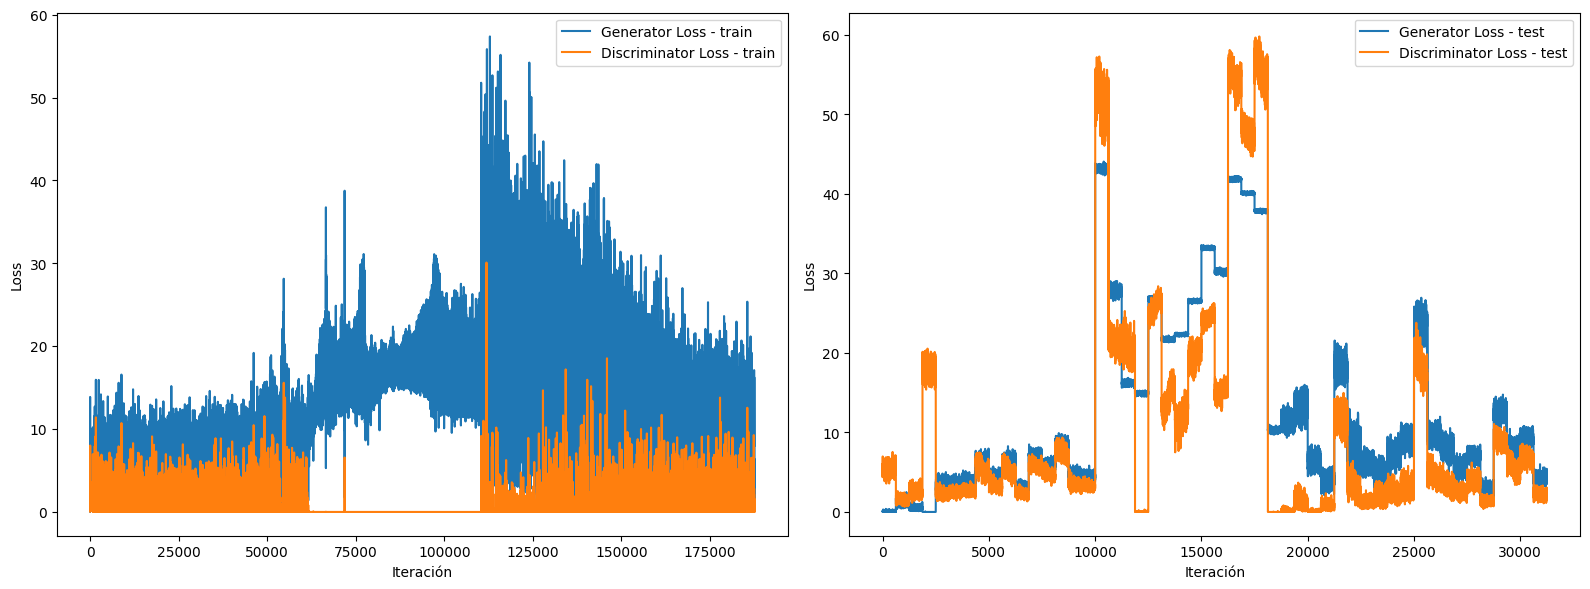

In [17]:
data = np.load("metricas_mnist_m3.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_itern_train']
d_loss_itern_test = data['d_loss_itern_test']
g_loss_itern_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

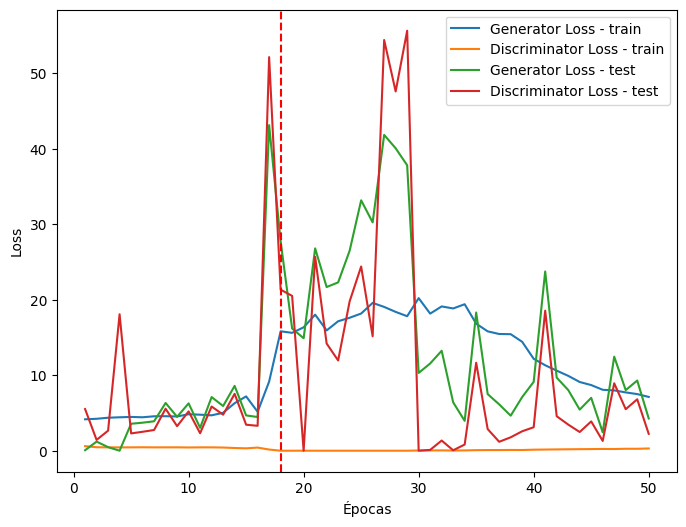

In [27]:
data = np.load("metricas_mnist_m3.npz")
epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.axvline(x=18, color='r', linestyle='--')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

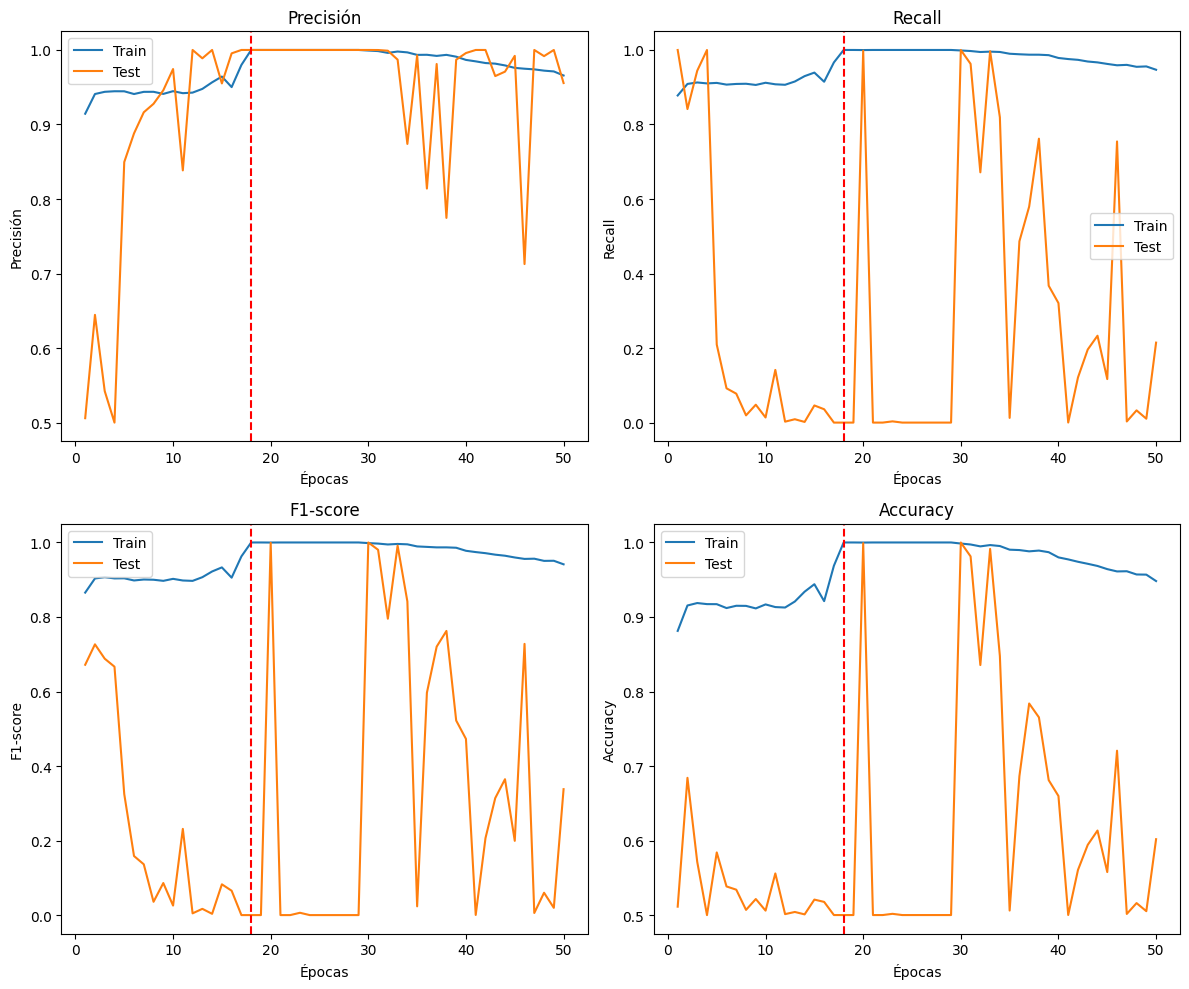

In [26]:
data = np.load("metricas_mnist_m3.npz")
epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].axvline(x=18, color='r', linestyle='--')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].axvline(x=18, color='r', linestyle='--')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].axvline(x=18, color='r', linestyle='--')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].axvline(x=18, color='r', linestyle='--')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()